# GHI Forecasting using PyTorch Models

This notebook implements deep learning models to forecast Global Horizontal Irradiance (GHI) based on various input features. The notebook is structured as follows:

1. **Data Loading and Exploration**: Load the pre-split train/validation/test datasets and explore their structure
2. **Data Preprocessing**: Prepare the data for model training (normalization, feature engineering)

## 1. Setup and Data Loading

First, let's import the necessary libraries and load the data.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import datetime
from pathlib import Path
from tqdm.notebook import tqdm

# PyTorch libraries
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")



Using cpu device


In [2]:
# Define data loading parameters

# Find all data files
train_files = [
    "data/raw/himawari7_2011_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2012_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2013_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2014_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2015_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2016_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2017_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2018_Hồ-Chí-Minh.h5",
]
val_files = [
    "data/raw/himawari7_2019_Hồ-Chí-Minh.h5",
]
test_files = [
    "data/raw/himawari7_2020_Hồ-Chí-Minh.h5",
]

print(f"Found {len(train_files)} training files: {[Path(f).name for f in train_files]}")
print(f"Found {len(val_files)} validation files: {[Path(f).name for f in val_files]}")
print(f"Found {len(test_files)} test files: {[Path(f).name for f in test_files]}")

# Check if the files exist
if not (train_files and val_files and test_files):
    print("Warning: Some data files are missing!")

# List of features to use
AVAILABLE_FEATURES = [
    'ghi',                     # Target variable
    'air_temperature',         # Weather features
    'wind_speed',
    'relative_humidity',
    'dew_point',
    'surface_pressure',
    'total_precipitable_water',
    'cloud_type',              # Cloud features
    'cloud_fill_flag',
    'cld_opd_dcomp',
    'cld_press_acha',
    'cld_reff_dcomp',
    'clearsky_ghi',            # Clear sky estimates
    'clearsky_dni',
    'clearsky_dhi',
    'solar_zenith_angle',      # Solar geometry
    'surface_albedo',          # Surface properties
    'ozone',                   # Atmospheric properties
    'aod',
    'ssa',
    'asymmetry',
    'alpha'
]

# Choose features which could be potentially useful for the modeling
# This is to reduce the number of features to be processed
# by excluding the features which are unrelevant to the target variable
# In the later modelling part, we will continue to select only subset of those features to input into the model
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',
    'cld_opd_dcomp',
    'cld_press_acha',
    'cld_reff_dcomp',
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'aod'
]

# Target variable
TARGET_VARIABLE = 'ghi'


Found 1 training files: ['himawari7_2011_Hồ-Chí-Minh.h5']
Found 1 validation files: ['himawari7_2019_Hồ-Chí-Minh.h5']
Found 1 test files: ['himawari7_2020_Hồ-Chí-Minh.h5']


### 1.1 Exploring the Data Structure

Let's examine the structure of our H5 files.

In [3]:
def explore_h5_structure(h5_path):
    try:
        with h5py.File(h5_path, 'r') as f:
            print(f"\nExploring {h5_path}")
            print("\nDatasets:")
            for key in f.keys():
                dataset = f[key]
                print(f"  /{key} {dataset.shape}: {dataset.dtype}")
                if key == 'meta':
                    # Explore metadata structure
                    print("  Metadata fields:")
                    for field in dataset.dtype.names:
                        values = dataset[field]
                        unique_count = len(np.unique(values))
                        sample = np.unique(values)[:5]
                        print(f"    {field}: {unique_count} unique values, examples: {sample}")
                elif len(dataset) > 0 and dataset.ndim > 0:
                    # For numerical data, show some statistics
                    try:
                        if dataset.dtype in [np.float32, np.float64, np.int16, np.int32, np.uint8, np.uint16]:
                            # Take a small sample to calculate stats
                            sample = dataset[:10, :100] if dataset.ndim > 1 else dataset[:10]
                            stats = {
                                'min': np.min(sample),
                                'max': np.max(sample),
                                'mean': np.mean(sample),
                                'has_nan': np.isnan(sample).any()
                            }
                            print(f"    Sample stats: {stats}")
                    except Exception as e:
                        print(f"    Error computing stats: {e}")
    except Exception as e:
        print(f"Error exploring {h5_path}: {e}")

# Explore first file from each set
if train_files:
    explore_h5_structure(train_files[0])
if val_files:
    explore_h5_structure(val_files[0])
if test_files:
    explore_h5_structure(test_files[0])



Exploring data/raw/himawari7_2011_Hồ-Chí-Minh.h5

Datasets:
  /air_temperature (17520, 105): int16
    Sample stats: {'min': np.int16(222), 'max': np.int16(289), 'mean': np.float64(262.133), 'has_nan': np.False_}
  /alpha (17520, 105): uint8
    Sample stats: {'min': np.uint8(108), 'max': np.uint8(153), 'mean': np.float64(134.02), 'has_nan': np.False_}
  /aod (17520, 105): uint16
    Sample stats: {'min': np.uint16(2236), 'max': np.uint16(4310), 'mean': np.float64(2966.096), 'has_nan': np.False_}
  /asymmetry (17520, 105): int8
  /cld_opd_dcomp (17520, 105): uint16
    Sample stats: {'min': np.uint16(0), 'max': np.uint16(8000), 'mean': np.float64(130.394), 'has_nan': np.False_}
  /cld_press_acha (17520, 105): uint16
    Sample stats: {'min': np.uint16(0), 'max': np.uint16(916), 'mean': np.float64(85.85), 'has_nan': np.False_}
  /cld_reff_dcomp (17520, 105): uint16
    Sample stats: {'min': np.uint16(0), 'max': np.uint16(1890), 'mean': np.float64(120.721), 'has_nan': np.False_}
  /clea

### 1.2 Raw Data Loading


In [4]:
from utils.data_loading_utils import load_dataset

# Load data with selected features
print("Loading training data...")
train_data = load_dataset(train_files, n_sites=None, features=SELECTED_FEATURES, target_variable="ghi", apply_scaling=True, time_interval="1h")
print("\nLoading validation data...")
val_data = load_dataset(val_files, n_sites=None, features=SELECTED_FEATURES, target_variable="ghi", apply_scaling=True, time_interval="1h")
print("\nLoading test data...")
test_data = load_dataset(test_files, n_sites=None, features=SELECTED_FEATURES, target_variable="ghi", apply_scaling=True, time_interval="1h")


Loading training data...
Loading from himawari7_2011_Hồ-Chí-Minh.h5...
  Using all available sites in the file
  Selected 105 sites
  Scaled solar_zenith_angle: range changed from [80.00, 17861.00] to [0.80, 178.61]
  Scaled clearsky_ghi: range changed from [0.00, 1033.00] to [0.00, 1033.00]
  Scaled ghi: range changed from [0.00, 1029.00] to [0.00, 1029.00]
Resampling data to 1h intervals...
  Resampling from 17520 original timesteps to '1h' frequency
  New timestep count: 8760
  Processing 9 time series variables
  Resampling categorical features: ['cloud_type']
    Processing cloud_type: sites 0-105 of 105


/mnt/d/Surrey/AI_and_Sustainability/EEEM073-Solar-Radiation/utils/data_loading_utils.py:476: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df = resampled_df.fillna(method='ffill').fillna(method='bfill')


  Resampling continuous features: ['air_temperature', 'wind_speed', 'relative_humidity', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'ghi']
    Processing air_temperature: sites 0-105 of 105
    Processing wind_speed: sites 0-105 of 105
    Processing relative_humidity: sites 0-105 of 105
    Processing solar_zenith_angle: sites 0-105 of 105
    Processing clearsky_ghi: sites 0-105 of 105
    Processing total_precipitable_water: sites 0-105 of 105
    Processing surface_albedo: sites 0-105 of 105
    Processing ghi: sites 0-105 of 105
Final data shapes:
  timestamps: (8760,)
  utc_timestamps: (8760,)
  latitude: (105,)
  longitude: (105,)
  elevation: (105,)
  timezone: (105,)
  time_index: (17520,)
  cloud_type: (8760, 105)
  air_temperature: (8760, 105)
  wind_speed: (8760, 105)
  relative_humidity: (8760, 105)
  solar_zenith_angle: (8760, 105)
  clearsky_ghi: (8760, 105)
  total_precipitable_water: (8760, 105)
  surface_albedo: (8760, 105)
  g

/mnt/d/Surrey/AI_and_Sustainability/EEEM073-Solar-Radiation/utils/data_loading_utils.py:476: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df = resampled_df.fillna(method='ffill').fillna(method='bfill')


  Resampling continuous features: ['air_temperature', 'wind_speed', 'relative_humidity', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'ghi']
    Processing air_temperature: sites 0-105 of 105
    Processing wind_speed: sites 0-105 of 105
    Processing relative_humidity: sites 0-105 of 105
    Processing solar_zenith_angle: sites 0-105 of 105
    Processing clearsky_ghi: sites 0-105 of 105
    Processing total_precipitable_water: sites 0-105 of 105
    Processing surface_albedo: sites 0-105 of 105
    Processing ghi: sites 0-105 of 105
Final data shapes:
  timestamps: (8760,)
  utc_timestamps: (8760,)
  latitude: (105,)
  longitude: (105,)
  elevation: (105,)
  timezone: (105,)
  time_index: (17520,)
  cloud_type: (8760, 105)
  air_temperature: (8760, 105)
  wind_speed: (8760, 105)
  relative_humidity: (8760, 105)
  solar_zenith_angle: (8760, 105)
  clearsky_ghi: (8760, 105)
  total_precipitable_water: (8760, 105)
  surface_albedo: (8760, 105)
  g

/mnt/d/Surrey/AI_and_Sustainability/EEEM073-Solar-Radiation/utils/data_loading_utils.py:476: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df = resampled_df.fillna(method='ffill').fillna(method='bfill')


  Resampling continuous features: ['air_temperature', 'wind_speed', 'relative_humidity', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'ghi']
    Processing air_temperature: sites 0-105 of 105
    Processing wind_speed: sites 0-105 of 105
    Processing relative_humidity: sites 0-105 of 105
    Processing solar_zenith_angle: sites 0-105 of 105
    Processing clearsky_ghi: sites 0-105 of 105
    Processing total_precipitable_water: sites 0-105 of 105
    Processing surface_albedo: sites 0-105 of 105
    Processing ghi: sites 0-105 of 105
Final data shapes:
  timestamps: (8784,)
  utc_timestamps: (8784,)
  latitude: (105,)
  longitude: (105,)
  elevation: (105,)
  timezone: (105,)
  time_index: (17568,)
  cloud_type: (8784, 105)
  air_temperature: (8784, 105)
  wind_speed: (8784, 105)
  relative_humidity: (8784, 105)
  solar_zenith_angle: (8784, 105)
  clearsky_ghi: (8784, 105)
  total_precipitable_water: (8784, 105)
  surface_albedo: (8784, 105)
  g

### 1.3 Visualize the Data

Location: Latitude 11.0100, Longitude 106.4200, Elevation 12m, Timezone UTC+7
Showing timesteps 0 to 47 out of 8760 total timesteps


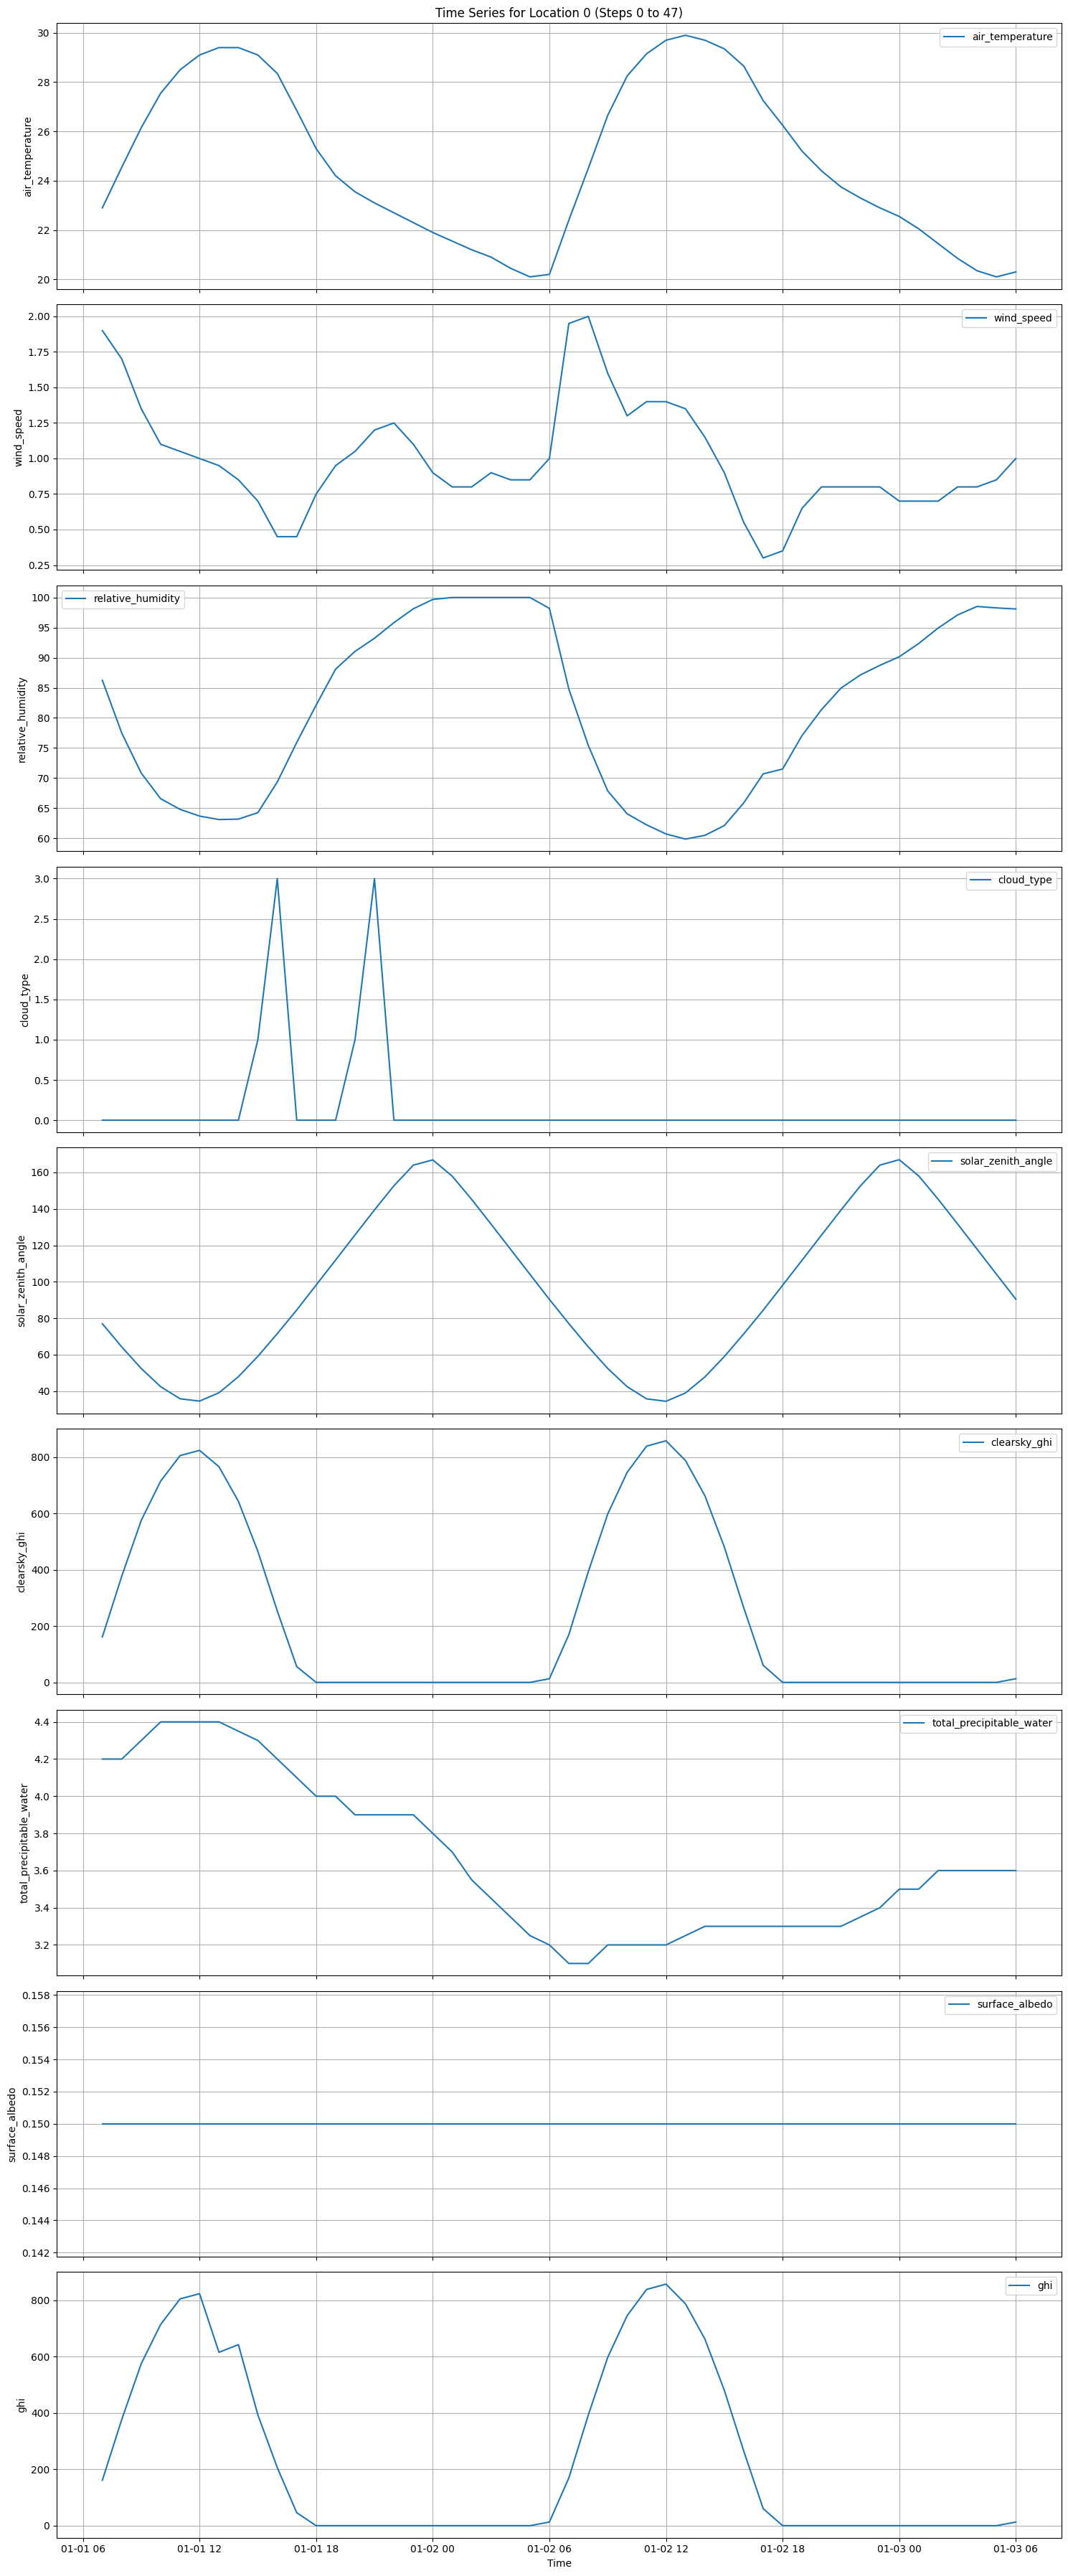

In [5]:
from utils.plot_utils import plot_time_series

# Plot data for a few locations
fig = plot_time_series(train_data,
                       features=SELECTED_FEATURES + ['nighttime_mask', "ghi"],
                       location_idx=0,
                       start_idx=0,
                       n_steps=48)


## 2. Data Preprocessing

### 2.1 Time Feature Engineering

In [6]:
from utils.normalize_utils import create_time_features

# Create time features
train_time_features = create_time_features(train_data['timestamps'])
val_time_features = create_time_features(val_data['timestamps'])
test_time_features = create_time_features(test_data['timestamps'])
print(f"Time features shape: {train_time_features.shape}")

train_data['time_features'] = train_time_features
val_data['time_features'] = val_time_features
test_data['time_features'] = test_time_features


Time features shape: (8760, 8)


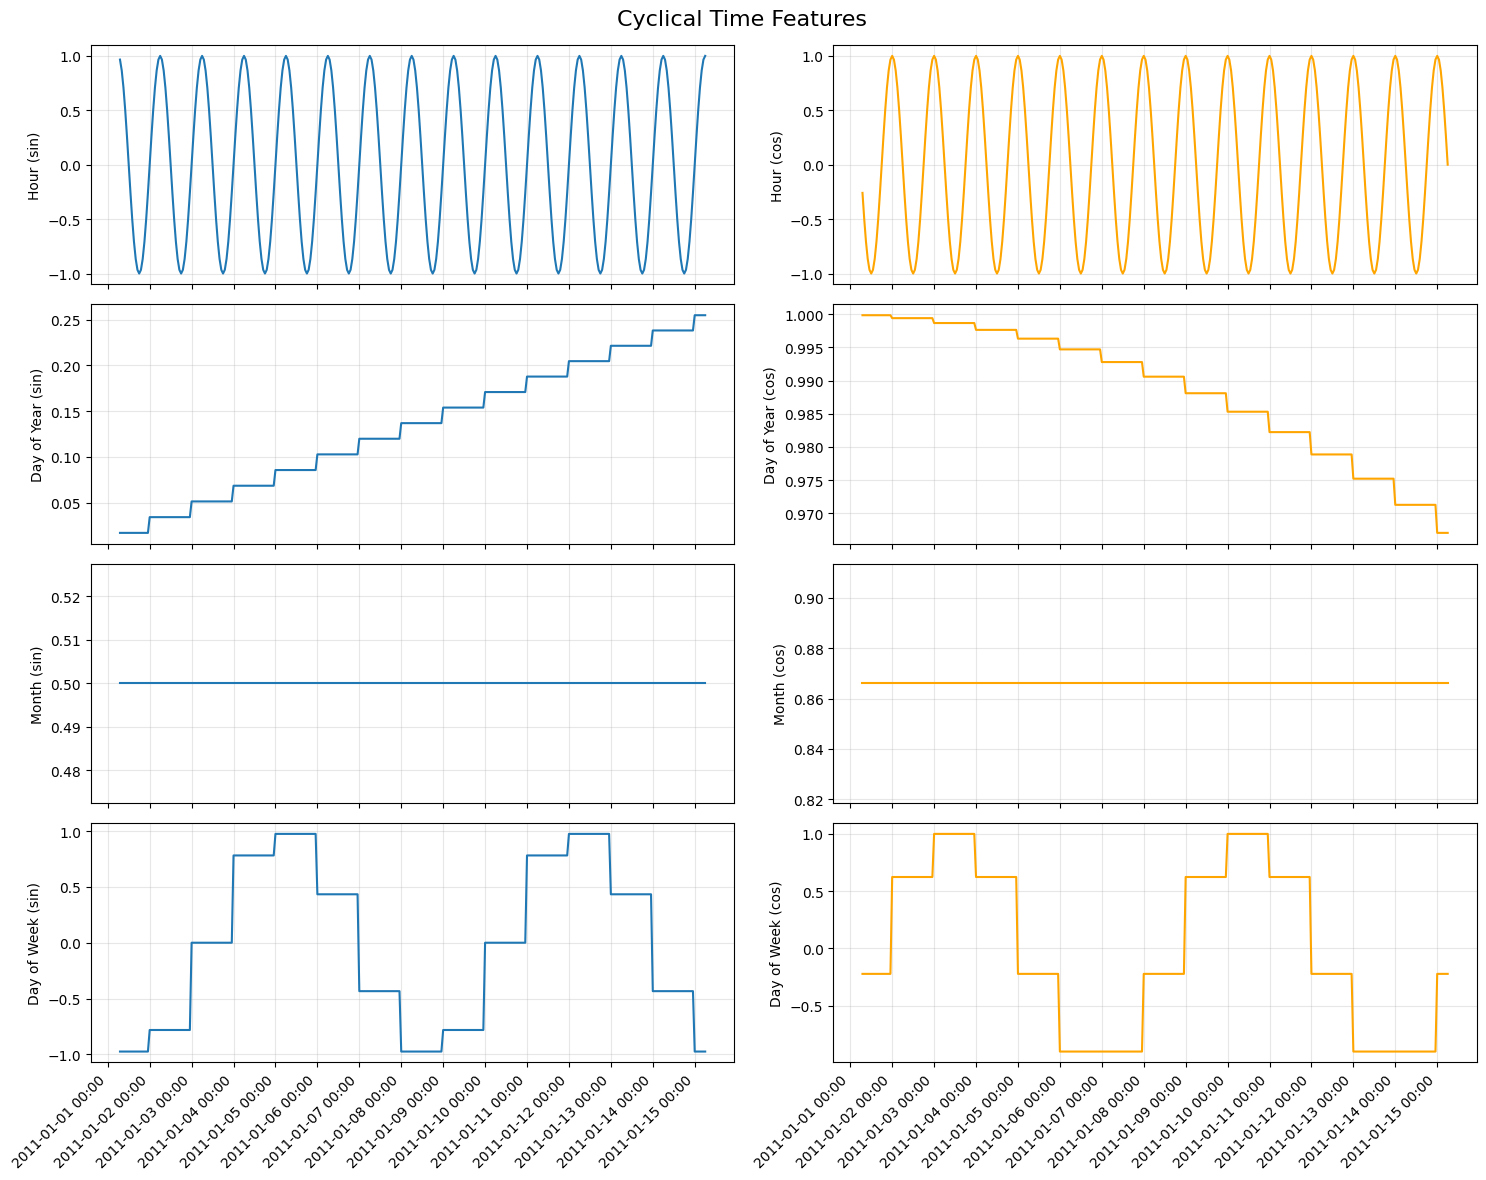

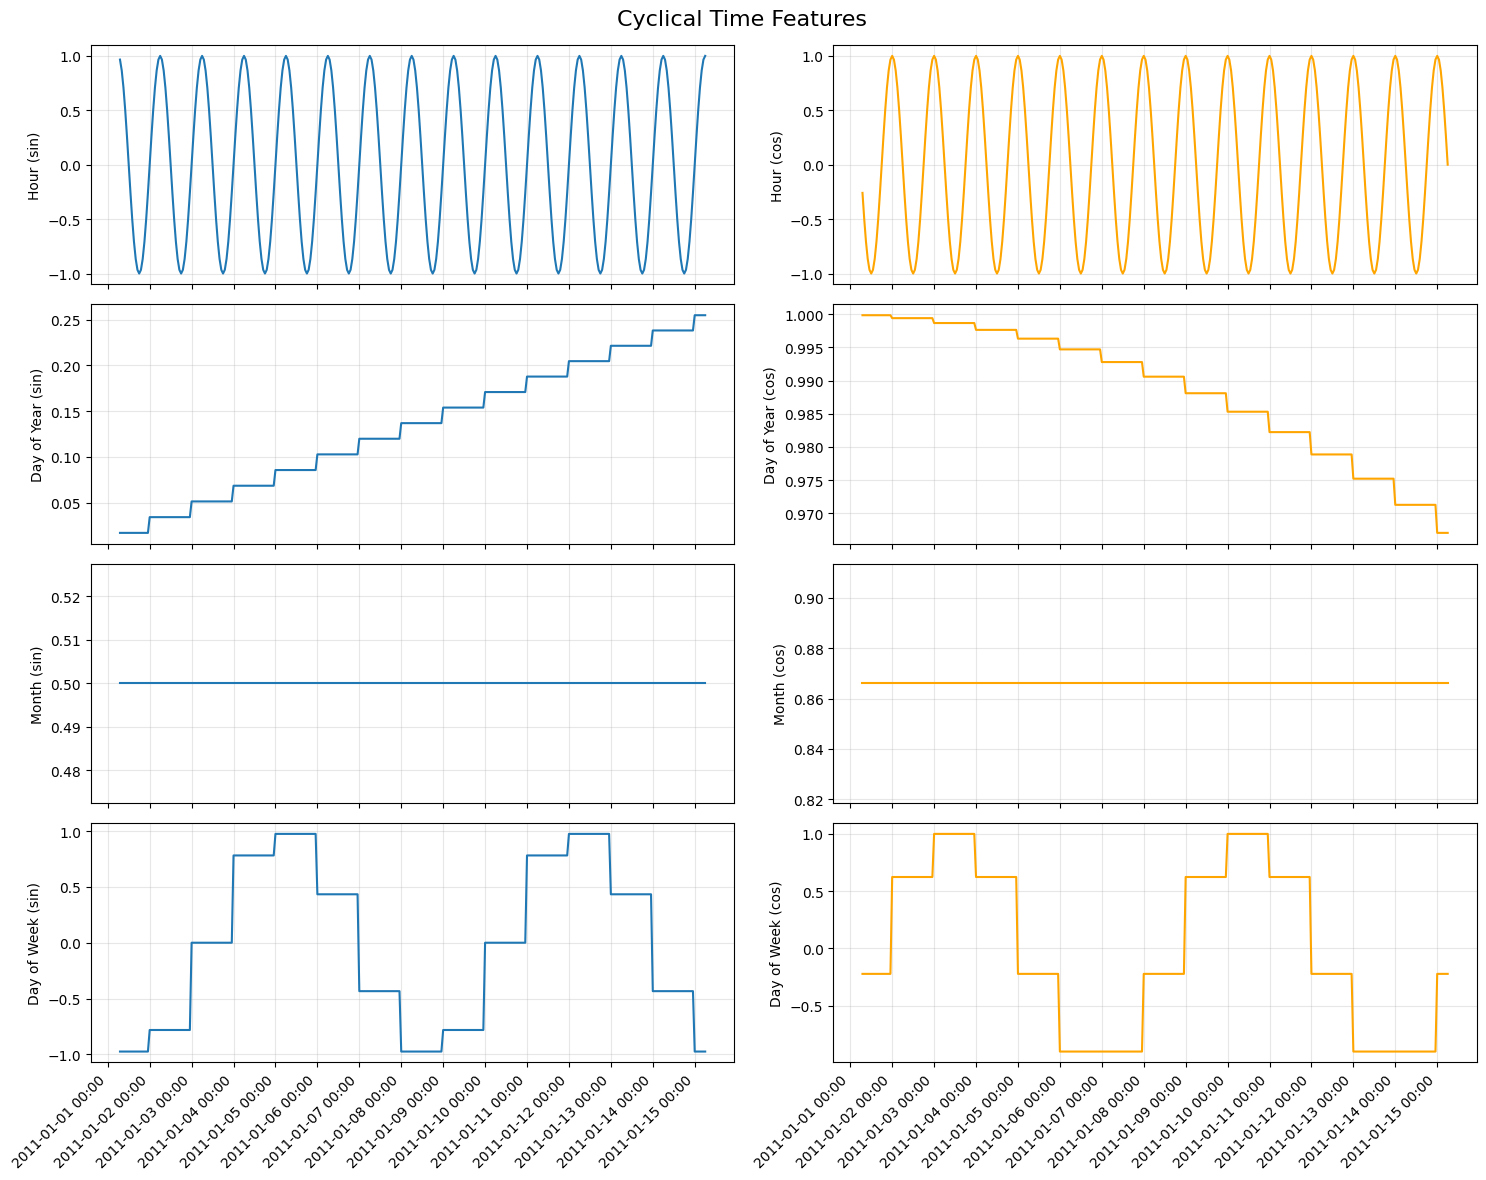

In [7]:
from utils.plot_utils import plot_time_features

plot_time_features(train_data['timestamps'], train_data['time_features'], n_days=14)


### 2.2 Create nighttime mask feature

In [8]:
from utils.features_utils import compute_nighttime_mask

# Compute nighttime mask using solar zenith angle if available
train_nighttime_mask = compute_nighttime_mask(
    train_data['timestamps'], train_data['latitude'], train_data['longitude'], train_data.get('solar_zenith_angle')
)
train_data['nighttime_mask'] = train_nighttime_mask
# Do the same for validation
val_nighttime_mask = compute_nighttime_mask(
    val_data['timestamps'], val_data['latitude'], val_data['longitude'], val_data.get('solar_zenith_angle')
)
val_data['nighttime_mask'] = val_nighttime_mask
# Do the same for test data
test_nighttime_mask = compute_nighttime_mask(
    test_data['timestamps'], test_data['latitude'], test_data['longitude'], test_data.get('solar_zenith_angle')
)
test_data['nighttime_mask'] = test_nighttime_mask
print(f"  Computed nighttime_mask with {np.sum(train_nighttime_mask)} night hours out of {train_nighttime_mask.size} total hours")

# Add nighttime mask to selected features if not already present
if "nighttime_mask" not in SELECTED_FEATURES:
    SELECTED_FEATURES += ["nighttime_mask"]


  Solar zenith angle data range: 4.470000000000001 to 176.32 (dtype: float64)
  Interpreted as degrees directly, range 4.47-176.32°
  Solar zenith angle data range: 4.460000000000001 to 176.32 (dtype: float64)
  Interpreted as degrees directly, range 4.46-176.32°
  Solar zenith angle data range: 4.455 to 176.32 (dtype: float64)
  Interpreted as degrees directly, range 4.46-176.32°
  Computed nighttime_mask with 461621.0 night hours out of 919800 total hours


Raw Solar Zenith Angle range: 34.39 to 167.005 (dtype: float64)
Display may be incorrect. SZA should be in degrees with ~0-180 range.
Location: Latitude 11.0100, Longitude 106.4200, Elevation 12m, Timezone UTC+7
Time period: 2011-01-01 07:00:00 to 2011-01-03 06:00:00
Day hours: 22.0 (45.8%), Night hours: 26.0 (54.2%)


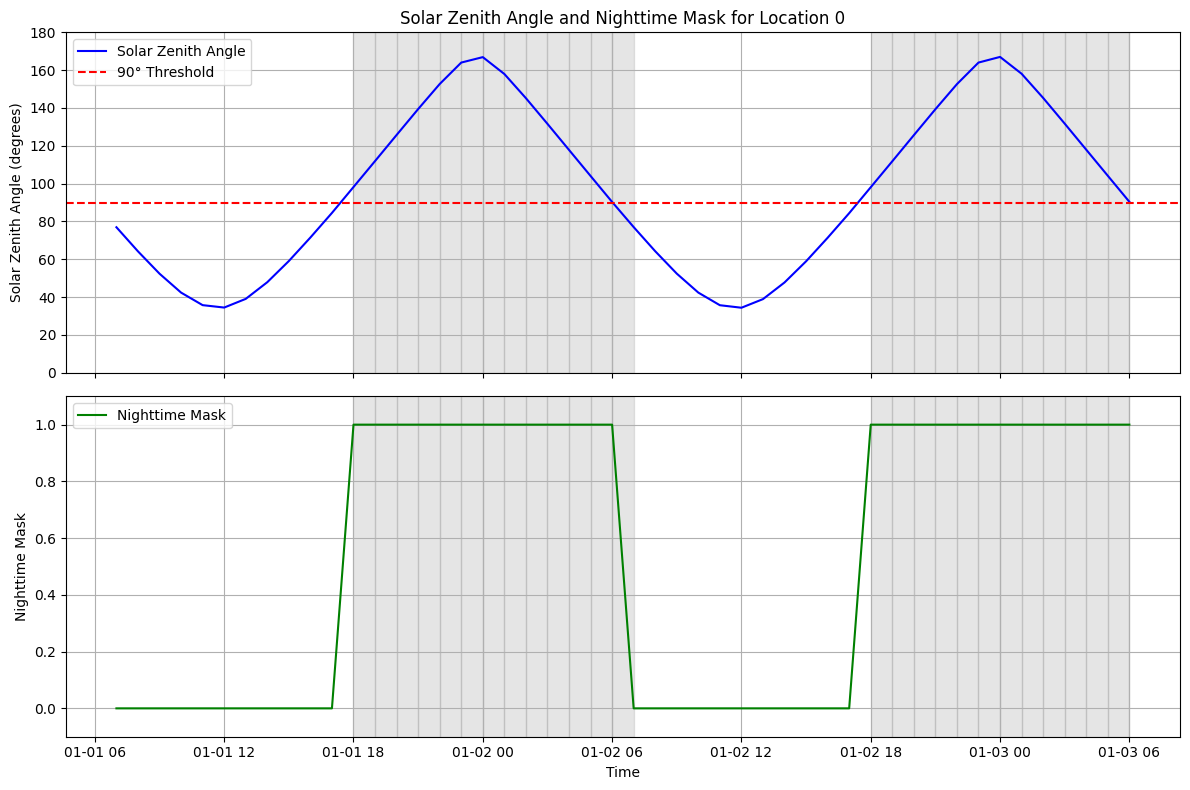

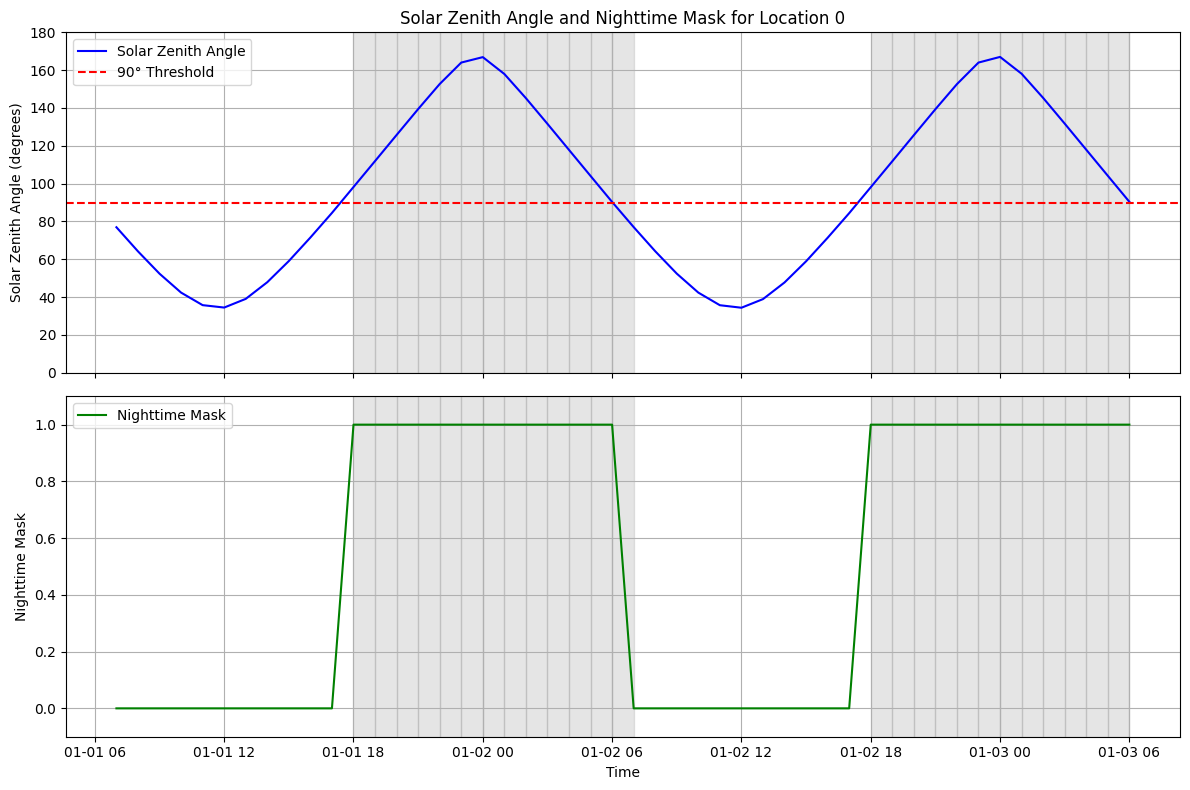

In [9]:
from utils.plot_utils import plot_solar_day_night

plot_solar_day_night(train_data, location_idx=0, n_steps=48, start_idx=0)


### 2.3 Create Clear Sky model (if not provided)

In [10]:
from utils.features_utils import compute_clearsky_ghi

# Use pre-computed clear sky GHI if available, otherwise compute it
if 'clearsky_ghi' not in train_data:
    clear_sky_ghi = compute_clearsky_ghi(
        train_data['timestamps'], train_data['latitude'], train_data['longitude'], train_data.get('solar_zenith_angle')
    )
    train_data['clearsky_ghi'] = clear_sky_ghi

if 'clearsky_ghi' not in val_data:
    clear_sky_ghi = compute_clearsky_ghi(
        val_data['timestamps'], val_data['latitude'], val_data['longitude'], val_data.get('solar_zenith_angle')
    )
    val_data['clearsky_ghi'] = clear_sky_ghi

if 'clearsky_ghi' not in test_data:
    clear_sky_ghi = compute_clearsky_ghi(
        test_data['timestamps'], test_data['latitude'], test_data['longitude'], test_data.get('solar_zenith_angle')
    )
    test_data['clearsky_ghi'] = clear_sky_ghi

if "clearsky_ghi" not in SELECTED_FEATURES:
    SELECTED_FEATURES += ["clearsky_ghi"]


Location: Latitude 11.0100, Longitude 106.4200, Elevation 12m, Timezone UTC+7
Showing timesteps 0 to 71 out of 8760 total timesteps


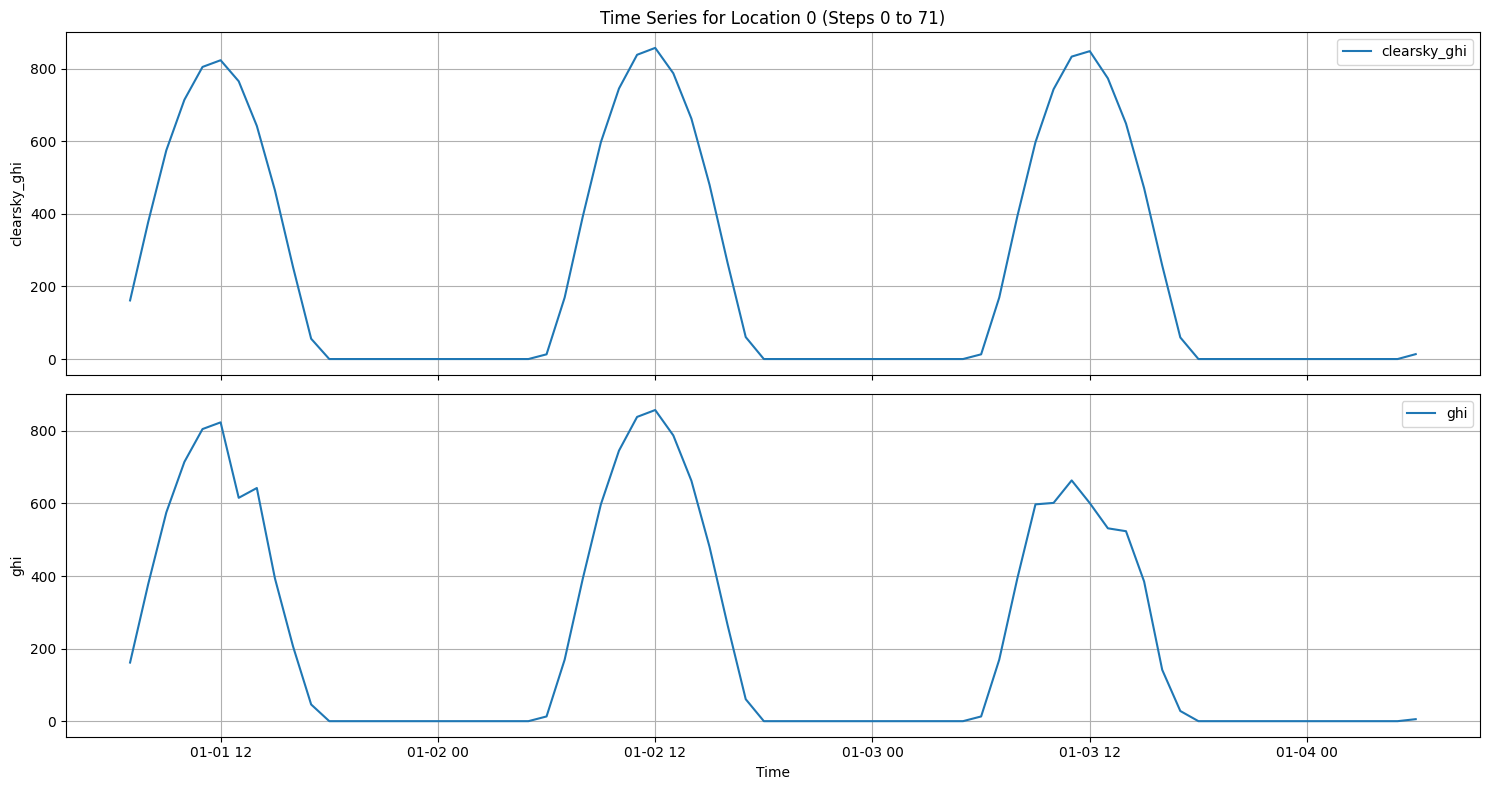

In [11]:
from utils.plot_utils import plot_time_series

# Plot data for a few locations
fig = plot_time_series(train_data,
                       features=["clearsky_ghi", "ghi"],
                       location_idx=0,
                       start_idx=0,
                       n_steps=72)


### 2.4 Data Normalization

In [12]:
from utils.normalize_utils import normalize_data

# Normalize data
norm_train_data, scalers = normalize_data(train_data, SELECTED_FEATURES, TARGET_VARIABLE, scalers=None, fit_scalers=True)
norm_val_data, _ = normalize_data(val_data, SELECTED_FEATURES, TARGET_VARIABLE, scalers=scalers, fit_scalers=False)
norm_test_data, _ = normalize_data(test_data, SELECTED_FEATURES, TARGET_VARIABLE, scalers=scalers, fit_scalers=False)

# Print normalized data shapes
print("Normalized data shapes:")
for key in norm_train_data:
    if isinstance(norm_train_data[key], np.ndarray):
        print(f"  {key}: {norm_train_data[key].shape}")


Normalized data shapes:
  time_features: (8760, 8)
  coordinates: (105, 2)
  elevation: (105,)
  nighttime_mask: (8760, 105)
  air_temperature: (8760, 105)
  wind_speed: (8760, 105)
  relative_humidity: (8760, 105)
  cloud_type: (8760, 105)
  solar_zenith_angle: (8760, 105)
  clearsky_ghi: (8760, 105)
  total_precipitable_water: (8760, 105)
  surface_albedo: (8760, 105)
  ghi: (8760, 105)


In [13]:
from utils.data_persistence import save_normalized_data, save_scalers

# Create metadata
train_metadata = {
    "selected_features": SELECTED_FEATURES,
    "target_variable": TARGET_VARIABLE,
    "selected_feature_org_shape": train_data[SELECTED_FEATURES[0]].shape,
    "target_org_shape": train_data[TARGET_VARIABLE].shape,
    "raw_files": train_files,
}
val_metadata = {
    "selected_features": SELECTED_FEATURES,
    "target_variable": TARGET_VARIABLE,
    "selected_feature_org_shape": val_data[SELECTED_FEATURES[0]].shape,
    "target_org_shape": val_data[TARGET_VARIABLE].shape,
    "raw_files": val_files,
}
test_metadata = {
    "selected_features": SELECTED_FEATURES,
    "target_variable": TARGET_VARIABLE,
    "selected_feature_org_shape": test_data[SELECTED_FEATURES[0]].shape,
    "target_org_shape": test_data[TARGET_VARIABLE].shape,
    "raw_files": test_files,
}

# Save normalized data
save_normalized_data(norm_train_data, output_dir="data/processed", prefix="train", add_timestamp=True)
save_normalized_data(norm_val_data, output_dir="data/processed", prefix="val", add_timestamp=True)
save_normalized_data(norm_test_data, output_dir="data/processed", prefix="test", add_timestamp=True)

# Save scalers
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_scalers(scalers, filepath=f"data/processed/scalers_{timestamp}.pkl")


Saved normalized data to data/processed/train_normalized.h5
Saved normalized data to data/processed/val_normalized.h5
Saved normalized data to data/processed/test_normalized.h5
Saved 12 scalers to data/processed/model_scalers.pkl


True